In [71]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm, matplotlib.font_manager as fm
%matplotlib inline

In [2]:
data = {"trt1": [1,2,3,4,5,6,7,8,9,10], "trt2": [40,50,60,70,70,60,50,30,40,20]}
df = pd.DataFrame(data)
print(df)

   trt1  trt2
0     1    40
1     2    50
2     3    60
3     4    70
4     5    70
5     6    60
6     7    50
7     8    30
8     9    40
9    10    20


# utils functions

In [168]:
# define the font styles
title_font = fm.FontProperties(family='serif', style='normal', size=19, weight='normal', stretch='normal')
label_font = fm.FontProperties(family='serif', style='normal', size=16, weight='normal', stretch='normal')
ticks_font = fm.FontProperties(family='serif', style='normal', size=10, weight='normal', stretch='normal')
annotation_font = fm.FontProperties(family='serif', style='normal', size=10, weight='normal', stretch='normal')
axis_bgcolor = '#f0f0f0'
# make a re-usable function to draw nice bar charts
def plot_hist(data, title='', xlabel='', ylabel='', color='cyan'):
    
    if type(data) == list:
        data = pd.Series(data)
    ax = data.hist(figsize=[9, 6], width=0.35, alpha=0.97, 
                   color=color, edgecolor='k', grid=False)

    ax.set_xticklabels(data.index, rotation=45, rotation_mode='anchor', ha='right')
    ax.yaxis.grid(True)
    #for label in ax.get_yticklabels():
    #    label.set_fontproperties(ticks_font)

    ax.set_facecolor(axis_bgcolor)   
    ax.set_title(title, fontproperties=title_font)
    ax.set_xlabel(xlabel, fontproperties=label_font)
    ax.set_ylabel(ylabel, fontproperties=label_font)

    plt.show()

Now our data is formatted in the format we want.

We just need to write `pd.category` specific test statistics functions.


That said, this is a big limitation. We should see if we can write it in other ways. It would be better to have test statistic functions that just use '**group_a** and **group_b** as inputs.

The above can be done. I should re-write format so that it includes 

In [6]:
def diff_means3(data, response, treatment):
    trt1 = data[treatment].cat.categories[0]
    trt2 = data[treatment].cat.categories[1]
    mean_diff = data[response][data[treatment]==trt1].mean() - data[response][data[treatment]==trt2].mean()
    return mean_diff

# Permutation Test

To do:
    Format data initialization so that the formatted data is automatic.
    This will require changing default arguments in `format_data_from_two_response`

In [169]:
class PermTest(object):
    
    
    def __init__(self, data):
        self.data = data
        self.formatted_data = None
        
        
        
    def format_data_from_two_response(self, response1, response2):
        """
        Converts data from a 2-column format (where each column refers to a treatment type) to
        a 2-column format where response is one column, treatment is the other.

        This is done for both efficiency of storage and test runtime.

        :param data: pandas DataFrame. each column must be of same length
        :return: pandas DataFrame in response, treatment format
        """
        # create new treatment Series
        nrow, ncol = self.data.shape
        treatment_column = pd.Series([self.data.columns.values[i]
                            for i in range(ncol)
                            for j in range(nrow)], dtype='category')

        # create response vector
        # TODO: 4 if/else for argument type
        if type(response1) == str and type(response2) == str:
            response_column = pd.concat([self.data.loc[:,response1],
                                         self.data.loc[:,response2]]).tolist()
        else:
            raise ValueError("response inputs must correspond to either column number(int) or name(str)")

        self.formatted_data = pd.DataFrame({"response": response_column,
                                      "treatment": treatment_column})

        
                
            
    def diff_means(self, response="response", treatment="treatment", data=None):
        """"""
        if data is None:
            trt1 = self.formatted_data[treatment].cat.categories[0]
            trt2 = self.formatted_data[treatment].cat.categories[1]

            mean_diff = self.formatted_data[response][self.formatted_data[treatment]==trt1].mean() \
            - self.formatted_data[response][self.formatted_data[treatment]==trt2].mean()

            return mean_diff
        else:
            trt1 = data[treatment].cat.categories[0]
            trt2 = data[treatment].cat.categories[1]

            mean_diff = data[response][data[treatment]==trt1].mean() \
            - data[response][data[treatment]==trt2].mean()

            return mean_diff
    
    
    def simPermDsn(self, response="response", treatment="treatment", test="mean", k=100):
        """
        Creates permutation dsn for our data
        :param data:
        :param hasTrt:
        :param testStat:
        :param k:
        :return:
        """
        df = self.formatted_data[:]
        testStatistics = []
        if test == "mean":
            for simulation in range(k):
                df[treatment] = pd.Series(np.random.permutation(self.formatted_data[treatment]),
                                            dtype='category')
                testStatistics.append(self.diff_means(response=response, treatment=treatment, data=df))

            return testStatistics
        
    def test(self, response="response", treatment="treatment", test="mean", k=100):
        
        if test == "mean":
            current_stat = self.diff_means(response=response, treatment=treatment)

            simulated_stats = self.simPermDsn(response=response, treatment=treatment, test=test, k=k)
            simulated_stats = np.array(simulated_stats)
            p_value = 1.0 * sum(abs(simulated_stats) >= abs(current_stat))/k

            return p_value
        
    def plot_dsn(self, response="response", treatment="treatment", test="mean", k=100):
        
        simulated_stats = self.simPermDsn(response=response, treatment=treatment, test=test, k=k)
        tit = "Permutation Test Statistic Distribution for k={} Simulations".format(k)
        plot_hist(simulated_stats, title=tit, xlabel="Test Statistic Value", ylabel="Frequency")
#         plt.hist(simulated_stats)
#         plt.title("Simulated Test Statistics of the {} for k={} Simulations".format(test,k))
#         plt.xlabel("Test Statistic Values")
#         plt.ylabel("Test Statistic Frequency")
#         plt.show()
        
      
    

Create data

In [132]:
data = pd.DataFrame({"treatment1":[1.5, 2, 5, 0.5, 4, 6.6, 4.5, 3, 4, 2.5],
                     "treatment2":[1, 5, 4, 3, 5, 6, 4, 3, 4.5, 3.2]})
data

,treatment1,treatment2
0,1.5,1.0
1,2.0,5.0
2,5.0,4.0
3,0.5,3.0
4,4.0,5.0
5,6.6,6.0
6,4.5,4.0
7,3.0,3.0
8,4.0,4.5
9,2.5,3.2


Create PermTest instance and formate data

In [170]:
pt = PermTest(data)
pt.format_data_from_two_response("treatment1","treatment2")
pt.formatted_data

,response,treatment
0,1.5,treatment1
1,2.0,treatment1
2,5.0,treatment1
3,0.5,treatment1
4,4.0,treatment1
5,6.6,treatment1
6,4.5,treatment1
7,3.0,treatment1
8,4.0,treatment1
9,2.5,treatment1


Calculate difference of means

In [134]:
print(pt.diff_means('response', 'treatment', data=None))

-0.5099999999999998


Create simulated distribution of test statistics (differences of means)

In [135]:
testsimdata = pt.simPermDsn(k=1000)

Visualize simulated distribution

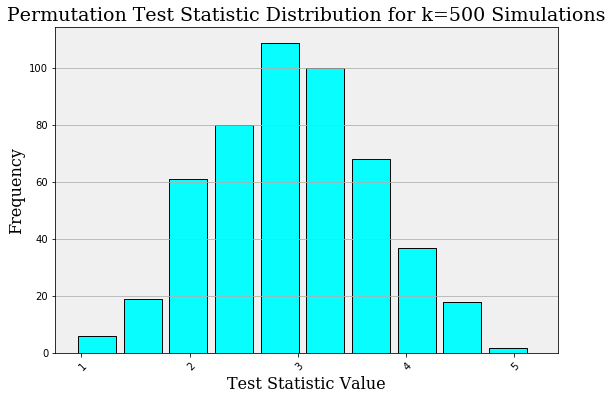

In [171]:
pt.plot_dsn(k=500)

Obtain p-value for test

In [118]:
pt.test()

0.41999999999999998

# Chi Squared Test

In [ ]:
chi_squared_values = []
for i in range(100):
    nums = np.random.random((32561,))
    ex = 32561/2
    nums[nums < 0.5] = 0
    nums[nums >= 0.5] = 1
    male = sum(nums==0)
    female = 32561-male
    male_diff = (male - ex)**2 / ex
    female_diff = (female - ex)**2 / ex
    chi_squared_values.append(male_diff + female_diff)
plt.hist(chi_squared_values)
plt.show()

In [ ]:
# return error if unequal lengths

In [164]:
def chi_squared_statistic(o,e):
    """"""
    
    o = np.array(o)
    e = np.array(e)
    return np.sum(1.0*(o - e)**2 / e)


class ChiSquaredTest():
    
    def __init__(self, observed=None, expected=None):
        self.observed = observed
        self.expected = expected
        
        
    def plot_dsn(self, k=100):
        simulated_stats = self.simPermDsn(k=k)
        tit = "Chi-Squared Test Statistic Distribution for k={} Simulations".format(k)
        plot_hist(simulated_stats, title=tit, xlabel="Test Statistic Value", ylabel="Frequency")
    
    
    def testStat(self, input_observed=None, input_expected=None):
        if input_observed or input_expected:
            chisq_teststat = chi_squared_statistic(input_observed, input_expected)
        else:
            chisq_teststat = chi_squared_statistic(self.observed, self.expected)
        return chisq_teststat
    
    def simPermDsn(self, input_observed=None, input_expected=None, k=100):
        if input_observed or input_expected:
            test_stat = self.testStat(input_observed, input_expected)
            n = len(input_observed)
        else:
            test_stat = self.testStat()
            n = len(self.observed)
            
        # create sampling distribution
        chisqrd_vals = []
        for i in range(k):
            values = np.random.random((n,))
            ex = 1.0*n/2
            values[values<.5]=0
            values[values>=.5]=1
            diff1 = chi_squared_statistic(sum(values==0),ex)
            diff2 = chi_squared_statistic(sum(values==1),ex)
            chisqrd_vals.append(diff1+diff2)
        return chisqrd_vals
    
    def test(self, input_observed=None, input_expected=None):
        
        current_stat = self.testStat(input_observed, input_expected)
        simulated_stats = self.simPermDsn(input_observed, input_expected)
        
        # p-value = proportion of test stats greater than ours
        p_value = 1.0*sum(simulated_stats >= current_stat) / len(simulated_stats)
        return p_value

Create data

In [160]:
obs = [26816, 3624, 1039, 311, 771]
ex = [26146.5, 3939.9, 1044.3, 310.5, 1119.8]
print(sum(obs))
print(sum(ex))

obs1 = [1,2,3,4,5]
ex1 = [1,2,2,4,5]

32561
32561.0


Create instance of `ChiSquaredTest`

In [165]:
chisq = ChiSquaredTest(obs, ex)

Get pvalue

In [166]:
chisq.test(obs1,ex1)

0.34000000000000002

View bootstrapped distribution

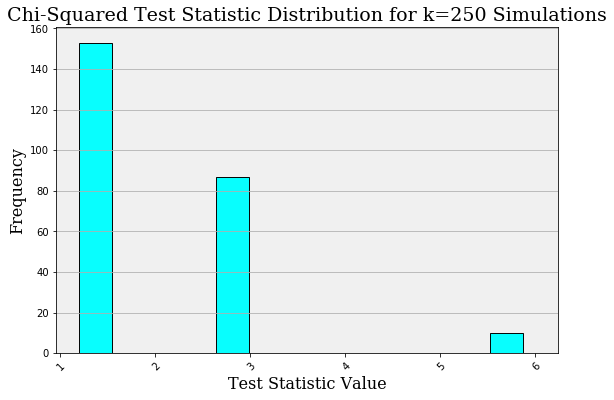

In [174]:
chisq.plot_dsn(k=250)

In [36]:
# To Implement

# Levene's Test for Unequal Variances
# Mann-Whitney Test    http://www.stat.wisc.edu/~st571-1/Fall2005/lec18-21.1.pdf
# t-test
# ANOVA  http://www.marsja.se/four-ways-to-conduct-one-way-anovas-using-python/
